本文综合采用国盛证券研报《多因子系列之一：多因子选股体系的思考》和中国银河证券研报《多因子系列：多因子模型体系之因子组合的确定》的研究思路，使用python代码复现研报内容。

因子组合的评判标准分为三类：因子暴露度、因子相关强度和因子选个股能力；选择因子组合，应综合考虑上述三个方面，选择暴露度高、相关强度低和选股能力强的因子。多因子模型构建流程主要包括：因子筛选、收益预测、风险预测和组合优化；本文复现的研究内容主要为因子筛选。

# Barra多因子模型

Barra结构化多因子模型利用一组共同因子和一个仅与该股票有关的特质因子解释股票的收益率，并利用共同因子和特质因子的波动来解释股票的波动率。首先对收益率进行简单的线性分解，将因子在第t期的暴露度与t+1期的股票收益进行线性回归，得到的回归系数即为因子在t期的因子收益率，第i只股票的线性分解如下所示：
<center>$r_i^(t+1) = X_h^tF_h^t+X_f^tF_f^t+\mu_i^t$ </center>
$r_i^(t+1)$：股票i在t+1期的收益率；
$X_h^t$：第t期在行业h上的收益率；
$F_h^t$：第t期在行业h上的暴露度（属于该行业则为1，不属于则为0）；
$X_f^t$：第t期因子f的收益率；
$F_f^t$：第t期在因子f上的暴露度；
$\mu_i^t$：股票i在第t期的残差收益。

也可写成矩阵表达式：
<center>$R = Xf+u$</center>

多因子模型主要由以下步骤组成：
<n>（1）单因子测试：选出解释度较高的特征因子
<n>（2）大类因子合成和模型构造
<n>（3）风险模型和组合优化


一般来讲，因子的选择有如下几种：

（1）市场整体：市场因子、系统性风险等;

（2）估值因子：市盈率、市净率、市销率、 市现率、 企业价值倍数、 PEG 等；

（3）成长因子：营业收入增长率、营业利润增长率、净利润增长率、每股收益增长率、净资产增长率、股东权益增长率、经营活动产生的现金流量金额增长率等；

（4）盈利能力因子：销售净利率、毛利率、净资产收益率、资产收益率、营业费用比例、财务费用比例、息税前利润与营业总收入比等；

（5）动量反转因子：前期涨跌幅等；

判断因子是否应该纳入组合的标准有：（1）因子是否通用，是否能代表基准明显的特征；（2）因子之间的相关性；（3）因子解释力度是否较强。

# 数据选取

股票数据基础基准设置为上证50（IH）、沪深300（IF）和中证500（IC）；下表中为上述三大指数的样本股编制规则：

| 指数名称      | 股票池           | 股票个数  |加权方法  |选股条件  |对应因子  |
| -------------|:-------------:| -----:| -----:| -----:| -----:|
| 上证 50       | 上证180     | 50     | 派许加权 + 调整股本     |规模、流动性     |流通市值、成交金额     |
| 沪深 300      | 全 A 股      |   300 |派许加权 + 调整股本     |规模     |日均总市值     |
| 中证 500      | 全 A 股扣除市值最大的 300 只|    500 |派许加权 + 调整股本     |规模     |日均总市值     |

从指数样本股选取标准上看，市值是重点考虑的方面。从加权方式上看股本需要加入初步的因子库。考虑到个股的通用性质，初步加入了ROE、 净利润增长率（成长性因子）、PE（价值因子）、换手率等因子。具体如下表所示：  

| 因子名称      | 计算方法           | 因子描述  |
| ------------- |:-------------:| -----:|
| 市值       | 总市值 = 个股当日股价 $\times$ 当日总股本  | 规模相关，信息包含股本和股价     | 
| 股本      | 报表科目，详见会计报表     |  规模相关 |
| EPS     | 当期净利润 / 普通股加权平均   |  业绩相关 |
| ROE      | 归属母公司股东的净利润占比 $\times$ 销售净利率 $\times$ 资产周转率 $\times$ 权益乘数     |  盈利能力相关 |
| 净利润增长率   | (本期 -上年同期调整数 ) / ABS上年同期调整数 $\times$ 100%   |  成长能力相关 |
| PE   | 市值 / 当期净利润   |  估值因子 |
| 换手率   | 成交量 / 总股数   |  行情相关 |

我们选取了估值、成长、行情等相关的风格因子。因为这些因子不但市场关注度较高，而且是 Barra 多因子框架中几个重要的风险因子。为了判断上证 50，沪深 300 和 中证 500 在历史上各因子的暴露情况，我们以日为频率测算因子相对于全市场的偏离程度。考虑可比性和统一标尺，我们使用的数据为因子当日的排序。计算步骤如下:   
（1） 将每日因子按照从大到小排序；  
（2） 从中取出属于某一指数的成份股，计算因子的排序平均值；  
（3） 暴露度= (指数因子排序平均值 - 当日全市场排序中间值)/当日股票总个数

数据处理部分：

In [ ]:
from jqdatasdk import *
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
auth('13511059588','0011qqQQ')

# 本代码为了简化运算量，使用2018年日数据
factors = ['Turnover', 'PE', 'MarketCap', 'Capitalization', 'EPS',\
           'ROE', 'NI_Growth_Ratio']
Fields = ['turnover_ratio', 'pe_ratio', 'market_cap', 'capitalization',\
          'eps', 'roe', 'inc_net_profit_year_on_year'] 
# 取出因子
# 得到fdate当天股票池中全A股的因子数据
def get_factors(fdate, factors):
    stockList = get_index_stocks('000002.XSHG',fdate)
    factors_list = query(valuation.code, valuation.turnover_ratio, \
                         valuation.pe_ratio, valuation.market_cap, \
                         valuation.capitalization, indicator.eps, \
                         indicator.roe, indicator.inc_net_profit_year_on_year\
                         ).filter(valuation.code.in_(stockList))
    stocks_fundamentals = get_fundamentals(factors_list, date=fdate) # 找到对应的因子数据
    stocks_fundamentals = stocks_fundamentals.set_index(['code'])
    return stocks_fundamentals

# 使用date_list记录开盘日期
def get_period_date(start_date, end_date):
    date_list = []
    current_date = start_date
    delta = datetime.timedelta(days=1)
    end_d = datetime.datetime.strptime(end_date,'%Y-%m-%d')
    current_d = datetime.datetime.strptime(current_date,'%Y-%m-%d')
    while (end_d-current_d).days >= 0:
        week_day = current_d.weekday()
        if week_day != 5 and week_day != 6:
            date_list.append(current_d.strftime('%Y-%m-%d'))
        current_d += delta
    return date_list

# 使用2018年数据
# 当然此处简单修改一下就可以包含更多年份
start_date = '2018-01-01'
end_date = '2018-12-31'
date_list = get_period_date(start_date, end_date)
factorData = {}
for date in date_list:
    # 按日期存储因子数据
    # factorData是全A股股票因子数据
    factorData[date] = get_factors(date,factors) 

计算因子暴露度：

In [ ]:
# 下面开始计算暴露度
def get_exposure(index):
    if index == 'SH50':
        index = '000016.XSHG'  
    if index == 'HS300':
        index = '000300.XSHG'
    if index == 'ZZ500':
        index = '000905.XSHG'
    expo = pd.DataFrame(index = date_list)
    for i in Fields:
        tempExposure = []
        for date in date_list:
            # 取出指数股票池中股票
            stockList = get_index_stocks(index, date)
            # 取出每日因子i
            temp = factorData[date][[i]]
            # 按照i因子降序排列
            temp = temp.sort_values([i],ascending = False)
            # 排序赋值
            temp['rank'] = range(len(temp)+1, 1, -1)
            # 获取指数因子排序平均值
            index_mean = temp.loc[stockList,'rank'].mean()
            # 全市场排序中间值
            middle = len(temp)//2
            # 得到暴露度
            tempExposure.append((index_mean-middle)/len(temp))
        expo[i] = tempExposure
    return expo

result_SH50 = []
result_HS300 = []
result_ZZ500 = []
expo1 = get_exposure('SH50')
expo2 = get_exposure('HS300')
expo3 = get_exposure('ZZ500')
for i in Fields:
    result_SH50.append(expo1[i].mean())
    result_HS300.append(expo2[i].mean())
    result_ZZ500.append(expo3[i].mean())

得到2018年三大指数的因子暴露度图表：

In [ ]:
fig = plt.figure(figsize=(15,6))
bar_width = 0.3
x = np.array(range(len(result_SH50)))
plt.bar(x, result_SH50, bar_width, label = 'SH50')
plt.bar(x+bar_width, result_HS300, bar_width, label = 'HS300')
plt.bar(x+bar_width+bar_width, result_ZZ500, bar_width, label = 'ZZ500')
plt.xticks(range(len(result_SH50)), factors)
plt.legend()
plt.show()

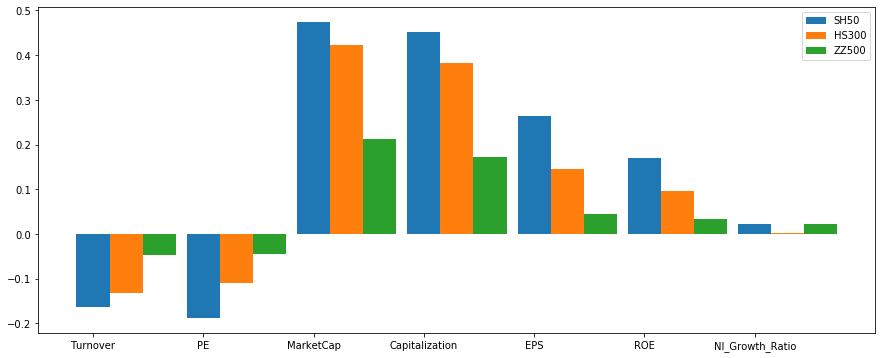

In [ ]:
fig1 = plt.figure()
x = np.array(range(len(result_SH50)))
plt.barh(x, result_SH50)
plt.yticks(range(len(result_SH50)), factors)
plt.title('SH50')
plt.show()

fig2 = plt.figure()
x = np.array(range(len(result_HS300)))
plt.barh(x, result_HS300)
plt.yticks(range(len(result_HS300)), factors)
plt.title('HS300')
plt.show()

fig3 = plt.figure()
x = np.array(range(len(result_ZZ500)))
plt.barh(x, result_ZZ500)
plt.yticks(range(len(result_ZZ500)), factors)
plt.title('ZZ500')
plt.show()

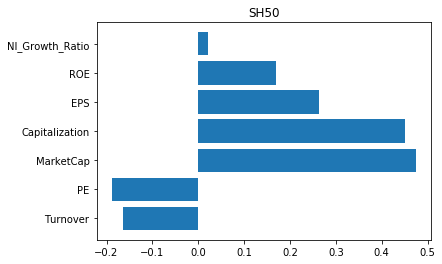

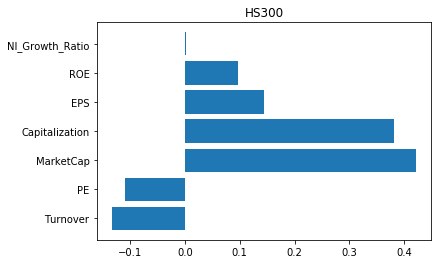

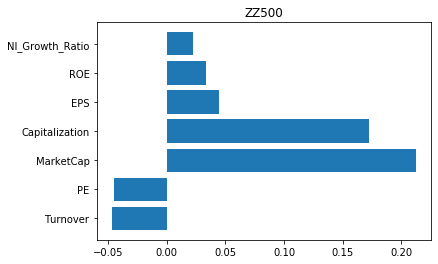

从以上图表可知：

1）市值和股本因子的偏离度最高。上证50的市值和股本因子的偏离度稳定 40%-50%，沪深 300的偏离度稳定在40%，而中证500市值和股本因子的偏离度在15%-25%之间。

2）中等偏离度的因子包括ROE、EPS、换手率和PE；

3）净利润增长因子偏离度几乎为0，大市值和小市值个股在成长性上差别较小；净利润增长因子的解释度较低，可以移出因子库。

# 因子相关性统计

## 相关性平均值

下表展示了各因子在上证50指数和沪深300指数中的相关性，测试数据使用2018年日数据。

In [ ]:
def getCorr(index):
    if index == 'SH50':
        index = '000016.XSHG'
    if index == 'HS300':
        index = '000300.XSHG'
    corr = {}
    for date in date_list:
        stockList = get_index_stocks(index, date)
        temp = factors_data[date].loc[stockList,:]
        corr[date] = temp.corr()
    corr = pd.Panel.from_dict(corr)
    return corr
corr_SH50 = getCorr('SH50')
corr_HS300 = getCorr('HS300')

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_SH50.mean(axis=0), annot=True, vmax=1, vmin=-0.5, cmap="Blues")
ax.set_title("SH50-Correlation Mean", fontsize=21)
fig.show()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_HS300.mean(axis=0), annot=True, vmax=1, vmin=-0.5, cmap="Blues")
ax.set_title("HS300-Correlation Mean", fontsize=21)
fig.show()

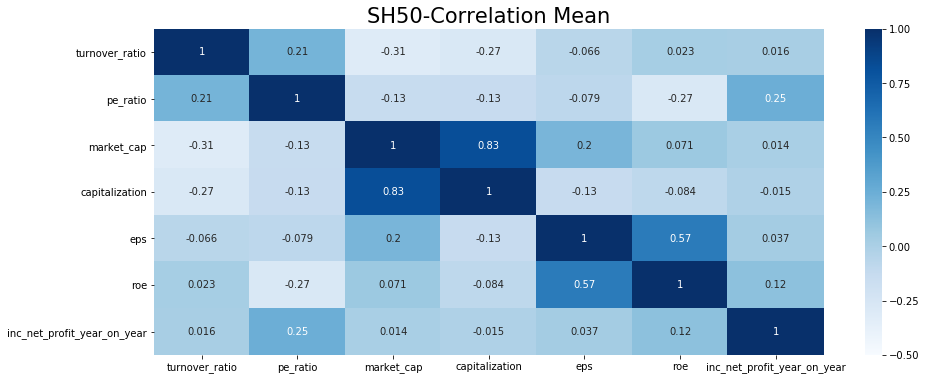

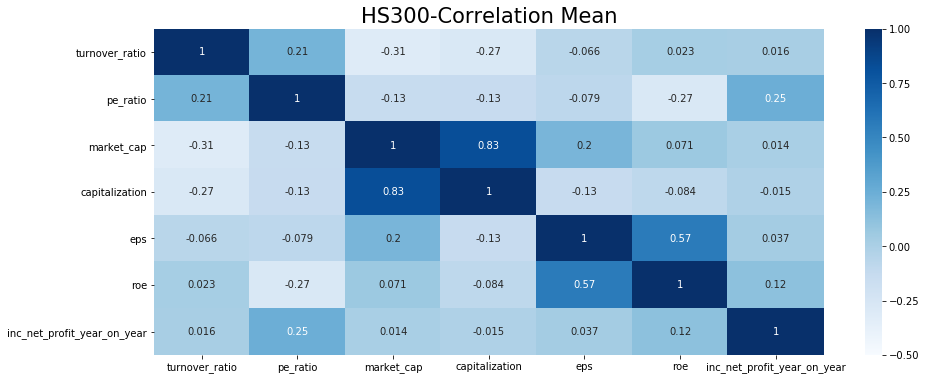

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_SH50.std(axis=0), annot=True, vmax=0.1, vmin=0, cmap="Blues")
ax.set_title("SH50-Correlation Standard Deviation", fontsize=21)
fig.show()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_SH50.mean(axis=0)/corr_SH50.std(axis=0), annot=True, vmax=5, vmin=-5, cmap="Blues")
ax.set_title("SH50-Correlation Intensity", fontsize=21)
fig.show()

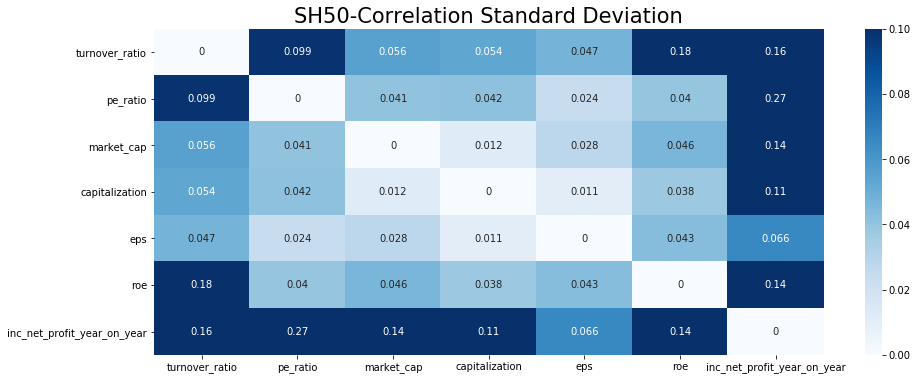

通过相关性的均值和标准差相除，我们可以得到判断因子相关性强弱的指标——相关强度；其绝对值越大，说明相关性越强。

计算公式为：
<center>$ x = mean(Corr)/std(Corr)$ </center>


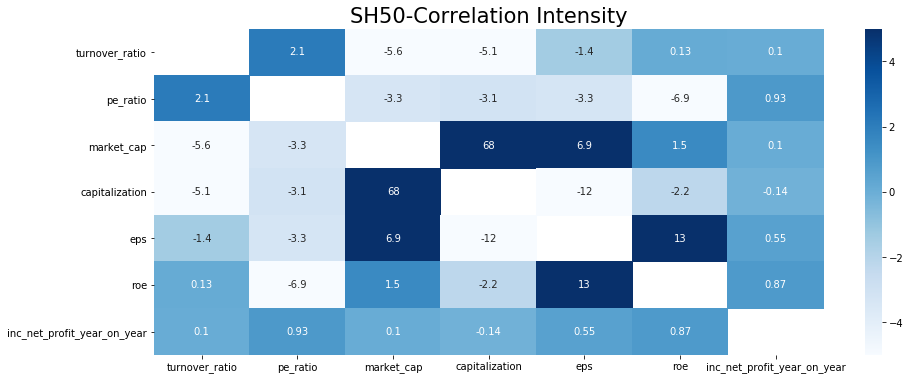

通过上述研究，我们可以得到：

（1）市值和股本因子的偏离度最高；中等偏离度的因子包括：换手率、ROE、PE、EPS；净利润增长因子由于偏离度过小，不适用于此模型。

（2）相关强度最低的组合为净利润增长率和成交量，换手率和EPS，ROE和换手率，股本和换手率。

（3）综上，换手率和股本作为因子组合较为合适。